<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_JB_data_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install scikit-image --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install cellpose --quiet

In [64]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models

In [65]:
def plot_point_data_pcol(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None,cmap='viridis'):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x]
        x=rad
        y=rad

    xy_slice = image_stack[z,:,:]
    zy_slice = image_stack[:,:,x].transpose([1,0])
    zx_slice = image_stack[:,y,:]

    vmin = np.percentile(image_stack,.1)
    vmax = np.percentile(image_stack,99.9)
    print(vmin,vmax)

    fig,ax=plt.subplots(2,3,width_ratios=[5, 1, .5],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax=ax.flatten()
    # ,aspect='auto'
    cbh=ax[0].pcolorfast(xy_slice,zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])
    ax[0].invert_yaxis()

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[3].imshow(zx_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[3].axvline(x,color='m',linewidth=lw)
    ax[3].axhline(z,color='y',linewidth=lw)

    plt.colorbar(cbh,cax=ax[2])

    for a in ax[4:]:
        a.axis('off')
    plt.tight_layout()
    return fig,ax,cbh

In [66]:
def plot_point_data_rgb(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    print(image_stack.shape,x,y)

    xy_slice = image_stack[z,:,:,:]
    zy_slice = image_stack[:,:,x,:].transpose([1,0,2])
    zx_slice = image_stack[:,y,:,:]


    z_ratio = image_stack.shape[0]/image_stack.shape[1]

    fig,ax=plt.subplots(2,2,width_ratios=[1, z_ratio],height_ratios=(1,z_ratio),figsize=figsize,dpi=300)
    ax=ax.flatten()

    ax[0].imshow(xy_slice,aspect='auto',zorder=-1) # vmin=vmin,vmax=vmax,cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[2].imshow(zx_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[2].axvline(x,color='m',linewidth=lw)
    ax[2].axhline(z,color='y',linewidth=lw)




    ax[3].axis('off')
    plt.tight_layout()
    return fig,ax



def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    tiff_format = 'zcyx'
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img


In [77]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF'
# """Off Site"""
# source_directory = 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF'

os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
curr_tif = my_tiffs[0]
display(my_tiffs)

['C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-E_20x2_1.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-E_20x2_2.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-F_20x2_1.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-F_20x2_2.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-G_20x2_1.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-G_20x2_2.tif',
 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-H_20x2_1.tif',
 'C:/Users/de

In [68]:
""" Propper Funcs """

def trim_edge_bound(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

def fit_cell_model(img_rgb, cell_channel=1, nuclear_channel=0,channel_axis=3):
    cell_diam=40
    cell_model = models.Cellpose(model_type='cyto3',gpu=True)
    (cell_masks, flows, styles, diams) = cell_model.eval(
        img_rgb, channels=[cell_channel,nuclear_channel],
        channel_axis = channel_axis, diameter=cell_diam,
        do_3D=False, stitch_threshold=0.02)

    results_dict = {'cell_masks':cell_masks,
                'flows':flows,
                'styles':styles,
                'diams':diams,
                'cell_model':cell_model,}
    return results_dict

def fit_nuclear_model(img_rgb,nuclear_channel=3,channel_axis=3):
    nuc_diam = None
    nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
    (nuclear_masks, _, _, _)=  nuclear_model.eval(
        img_rgb, channels=[nuclear_channel, 0],
        channel_axis = channel_axis, diameter=nuc_diam,
        do_3D=False, stitch_threshold=0.02,)
    return nuclear_masks

def tiff_to_RGB_stack(tiff_data,rbg_channel_order = [1,0,0]):
    tiff_data = tiff_data[:,rbg_channel_order,:,:]
    tiff_data[:,1,:,:]=0
    rgb_stack = tiff_data.transpose([0,2,3,1])*225
    rgb_stack[rgb_stack<0]=0
    rgb_stack[rgb_stack>255]=255
    rgb_stack=rgb_stack.astype('uint8')
    return rgb_stack

def preprocess_image(tiff_data):
    tiff_data = ski.filters.gaussian(
        tiff_data, sigma=[1,1,1],
        mode='reflect',truncate = 4,
        channel_axis=1)
    tiff_data = med_filt_stack(tiff_data,5)
    tiff_data = norm_channels(tiff_data,'zcxy',clip=True,pct=[99,1])
    return tiff_data

def split_proj(tiff_data):
    print(tiff_data.shape)
    num_c = tiff_data.shape[3]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Reds','Greens','Blues','gray']
    for c in range(num_c):
        ax[c].imshow(np.max(tiff_data[:,:,:,c],axis=0), cmap=colors[c],vmin=0,vmax=255)
        ax[c].axis('off')
    plt.tight_layout()


def norm_channels(im_data,tiff_format,clip=False,pct=[99,1]):
    print(im_data.shape)
    color_dim = tiff_format.index('c')
    print('norm color dim =',color_dim)
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),pct)
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data




'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-E_20x2_1.tif'

In [69]:
def save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    np.save( image_name+'_cell_masks',cell_masks,allow_pickle=True)
    np.save( image_name+'_nuclear_masks',nuclear_masks,allow_pickle=True)
    np.save( image_name+'_cell_masks_og',cell_masks_og,allow_pickle=True)



In [ ]:
"""MAIN"""

def qunatify_image_stack(curr_tif):
    tiff_data_raw = tifffile.imread(curr_tif)
    tiff_data = preprocess_image(tiff_data_raw)
    rgb_stack = tiff_to_RGB_stack(tiff_data)
    split_proj(rgb_stack)

    nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
    results_dict = fit_cell_model(rgb_stack,channel_axis=3)
    cell_masks = results_dict['cell_masks']
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif)


# fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=300)
# ax[0].pcolorfast(np.sum(nuclear_masks,axis=0))
# ax[1].pcolorfast(np.sum(cell_masks,axis=0))


for curr_tif in my_tiffs:
    qunatify_image_stack(curr_tif)

In [168]:
curr_tif

'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF\\DAPI-NeuN_E3-E_20x2_1.tif'

In [81]:
def load_masks(curr_tif):
    image_name = os.path.splitext(os.path.basename(curr_tif))[0]
    cell_masks = np.load( image_name+'_cell_masks.npy')
    nuclear_masks = np.load( image_name+'_nuclear_masks.npy')
    cell_masks_og = np.load( image_name+'_cell_masks_og.npy')
    return (cell_masks,nuclear_masks,cell_masks_og)

In [638]:
curr_tif
found_cells = np.sum(cell_masks>0,axis=0)
tifffile.imwrite('found_cells.tif',found_cells)
# plt.imshow(found_cells)

tiff_data_raw = tifffile.imread(curr_tif)
neun_slice = tiff_data_raw[14,1,:,:]
tifffile.imwrite('neun_slice.tif',neun_slice)

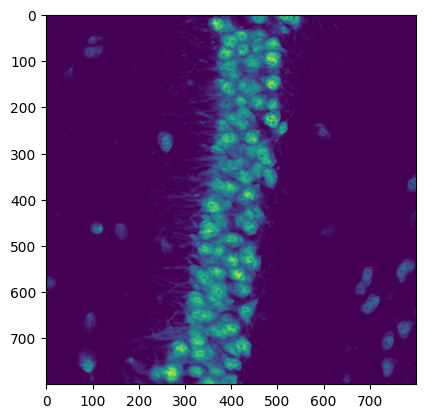

In [637]:
tiff_data_raw.shape
plt.imshow(tiff_data_raw[14,1,:,:])



In [256]:
def find_child_nucleii(cell_masks,nuclear_masks,cell_df):
    cell_df['nucleii']=np.nan
    cell_df['nuc_count']=np.nan
    cell_df['nucleii']=cell_df['nucleii'].astype(object)
    for cell in cell_df.index:
        cell_nuc_overlap = nuclear_masks [cell_masks==cell]
        cell_nuc_overlap=[n for n in cell_nuc_overlap if n>0]
        cell_df.at[cell,'nucleii'] = np.unique(cell_nuc_overlap)
        cell_df.at[cell,'nuc_count'] = cell_df.at[cell,'nucleii'].size
    return cell_df


def analyze_ferrets(cell_df,cell_masks,voxel_dim_um):

    cell_df['feret_d']=np.nan
    cell_df['feret_d']= cell_df['feret_d'].astype(object)
    for id in cell_df.index:
        cell_df.at[id,'feret_d'] = nd_feret(cell_masks==id,zxy_scalars=voxel_dim_um[[2,0,1]])

    ferrets = cell_df['feret_d'].to_numpy()
    ferrets = np.stack(ferrets,axis=0)
    cell_df['feret_z'] = ferrets[:,0]
    cell_df['feret_x'] = ferrets[:,1]
    cell_df['feret_y'] = ferrets[:,2]
    cell_df['min_fer'] = np.min(ferrets,axis=1)
    cell_df['box_vol'] = np.prod(ferrets,axis=1)
    cell_df['pct_fill'] = cell_df['sizes_um3']/cell_df['box_vol']

    return cell_df

def nd_feret(mask,zxy_scalars=None):
    if zxy_scalars is None:
        scalars=np.ones_like(mask.shape)
    n_coords=np.where(mask)
    feret_diams = list()
    for s, coord in zip(zxy_scalars,n_coords):
        diam = np.max(coord)-np.min(coord)+1
        feret_diams.append(diam*s)
    return np.asarray(feret_diams)

In [509]:
def analyze_cell_mask(cell_masks,nuclear_masks):


    voxel_dim_um=np.array([0.3977476,0.3977476,0.5])
    voxel_vol_um3 = np.prod(voxel_dim_um)

    cell_masks_f = cell_masks.flatten()
    cell_ids = np.unique(cell_masks_f)
    bins = np.insert(cell_ids+0.5, 0, -0.5, axis=0)
    (sizes_px, edges) = np.histogram(cell_masks_f,bins=bins)
    sizes_um3 = sizes_px*voxel_vol_um3

    # print('\n',len(cell_ids),len(sizes_px),len(sizes_um3))
    cell_df = pd.DataFrame({'cell_ids':cell_ids[1:],'sizes_px':sizes_px[1:],
                            'sizes_um3':sizes_um3[1:]}).set_index('cell_ids')

    cell_df =  analyze_ferrets(cell_df,cell_masks,voxel_dim_um)
    cell_df = find_child_nucleii(cell_masks,nuclear_masks,cell_df)

    """ FILTERING """
    cell_df = cell_df[cell_df['nuc_count']<2]
    cell_df = cell_df[cell_df['pct_fill']>.4]
    cell_df = cell_df[cell_df['min_fer']>1]

    return cell_df['sizes_um3'].values, cell_df




100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:22<00:00,  6.85s/it]


In [603]:
my_tiffs_ones = [t for t in my_tiffs if '_1.tif' in t]
my_tiffs_twos = [t for t in my_tiffs if '_2.tif' in t]

tiff_list = my_tiffs

volumes_lists = list()
for curr_tif in tqdm(tiff_list):
    (cell_masks,nuclear_masks,cell_masks_og) = load_masks(curr_tif)
    volumes, df = analyze_cell_mask(cell_masks,nuclear_masks)
    volumes_lists.append(volumes)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:41<00:00,  6.72s/it]


In [ ]:
vol_resolution = 50

combined_vols = np.concatenate(volumes_lists)
counts, edges = np.histogram(combined_vols,bins=np.arange(0,1800,vol_resolution))
bin_centers = edges[1:] - np.diff(edges)/2
prob = counts/np.sum(counts)
plt.stairs(np.cumsum(prob),edges,color='k')
vol_dist_df=pd.DataFrame({'tiff':tiff_list,'volume_lists':volumes_lists}).set_index('tiff')
# display(vol_dist_df.head())



"""
combine slices 1 and 2
"""
vol_dist_df_consolidated = vol_dist_df.copy()
for tiff in my_tiffs_ones:
    tiff_match = tiff.replace('_1.tif','_2.tif')
    one_vols = vol_dist_df_consolidated.loc[tiff,'volume_lists']
    two_vols = vol_dist_df_consolidated.loc[tiff_match,'volume_lists']
    vol_dist_df_consolidated.at[tiff,'volume_lists'] = np.concatenate([one_vols,two_vols])
    vol_dist_df_consolidated = vol_dist_df_consolidated.drop(tiff_match,axis=0)
display(vol_dist_df_consolidated)

vol_dist_df = vol_dist_df_consolidated
tiff_list = list(vol_dist_df.index)

In [ ]:

vol_dist_df['counts']=np.nan
vol_dist_df['counts']=vol_dist_df['counts'].astype('object')
vol_dist_df['edges']=np.nan
vol_dist_df['edges']=vol_dist_df['edges'].astype('object')
vol_dist_df['probabilities']=np.nan
vol_dist_df['probabilities']=vol_dist_df['probabilities'].astype('object')



for tiff in vol_dist_df.index:
    vols = vol_dist_df.loc[tiff,'volume_lists']
    counts, edges = np.histogram(vols,bins=np.arange(0,1800,vol_resolution))
    cd_probs = np.cumsum(counts/np.sum(counts))
    # plt.stairs(np.cumsum(prob),edges)
    vol_dist_df.at[tiff,'edges']=edges
    vol_dist_df.at[tiff,'counts']=counts
    vol_dist_df.at[tiff,'probabilities']=cd_probs

vol_dist_df['geno'] = ['E4' if 'E4' in t else 'E3' for t in vol_dist_df.index]
display(vol_dist_df.head(3))



sorted(my_tiffs)

ages = [10,10,
        10,10,
        10,10,
        5,5,
        5,5,
        5,5,
        10,10,
        10,10,
        10,10,
        5,5,
        5,5,
        5,5,]

ages = [10,
        10,
        10,
        5,
        5,
        5,
        10,
        10,
        10,
        5,
        5,
        5,]



age_dict = {t:a for t,a in zip(tiff_list,ages)}
df_ages = [age_dict[t] for t in vol_dist_df.index]
vol_dist_df['age'] = df_ages

In [606]:
# obs_abs_delta, obs_raw_delta = eval_sample(true_key,joint_cdf_mat)
# obs_raw_delta.shape
X = obs_raw_delta>0

import skimage

def analyze_full_delta(raw_delta):
    positives = skimage.measure.label(raw_delta>0)
    positives_chunks = np.unique(positives)
    positives_chunks = [p for p in positives_chunks if p>0]
    if len(positives_chunks)>0:
        pos_patch_area = [np.sum(positives==p) for p in positives_chunks]
        pos_patch_density = [np.sum(raw_delta[positives==p]) for p in positives_chunks]
        max_pos_area = np.max(pos_patch_area)
        max_pos_density = np.max(pos_patch_density)
    else:
        max_pos_area=0
        max_pos_density=0


    negatives = skimage.measure.label(raw_delta<0)
    negatives_chunks = np.unique(negatives)
    negatives_chunks = [p for p in negatives_chunks if p>0]
    if len(negatives_chunks)>0:
        neg_patch_area = [np.sum(negatives==p) for p in negatives_chunks]
        neg_patch_density = [np.sum(raw_delta[negatives==p]) for p in negatives_chunks]
        max_negative_area = np.max(neg_patch_area)
        min_negative_intensity = np.min(neg_patch_density)

    else:
        max_negative_area=0
        min_negative_intensity=0

    return np.asarray([max_pos_area, max_pos_density, max_negative_area, min_negative_intensity])


analyze_full_delta(obs_raw_delta)

array([11.        ,  0.07498969,  9.        , -0.42633357])

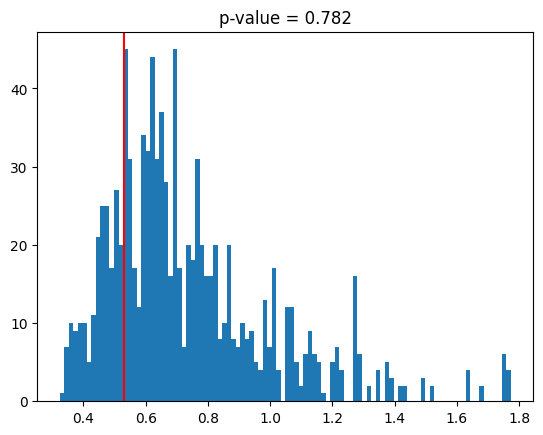

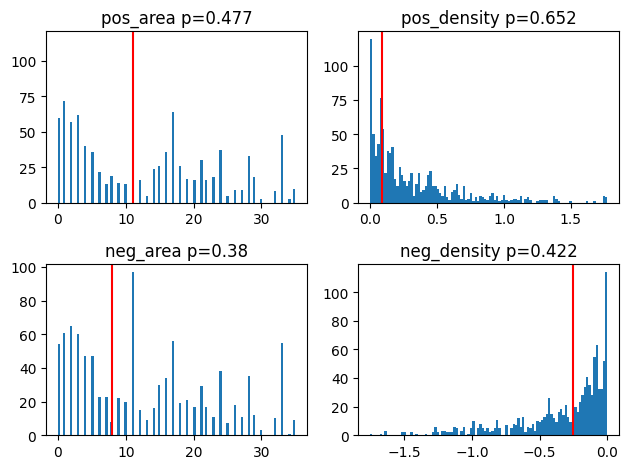

In [607]:
# cdf_mat =


def permute_cdf_test(true_key,joint_cdf_mat,n_per=1000):
    obs_abs_delta, obs_raw_delta = eval_sample(true_key,joint_cdf_mat)
    obs_delta_stats = analyze_full_delta(obs_raw_delta)
    perm_delta_list = list()
    perm_delta_raw_list = list()
    for a in np.arange(n_per):
        perm_key = true_key.copy()
        np.random.shuffle(perm_key)
        perm_abs_delta, perm_full_delta = eval_sample(perm_key,joint_cdf_mat)
        perm_delta_list.append(perm_abs_delta)
        perm_delta_raw_stats = analyze_full_delta(perm_full_delta)
        perm_delta_raw_list.append(perm_delta_raw_stats)
    perm_delta_raw_arr = np.stack(perm_delta_raw_list)

    fig,ax=plt.subplots(1)
    ax.hist(perm_delta_list,bins=100)
    ax.axvline(obs_abs_delta,color='r')
    pval = np.mean(obs_abs_delta>=perm_delta_list)
    ax.set_title(f'p-value = {1-pval}')

    fig,ax=plt.subplots(2,2)
    ax=ax.flatten()
    ax[0].hist(perm_delta_raw_arr[:,0],bins=100)
    ax[0].axvline(obs_delta_stats[0],color='r')
    ax[0].set_title(f'pos_area p={np.mean(obs_delta_stats[0]<perm_delta_raw_arr[:,0]) }')

    ax[1].hist(perm_delta_raw_arr[:,1],bins=100)
    ax[1].axvline(obs_delta_stats[1],color='r')
    ax[1].set_title(f'pos_density p={np.mean(obs_delta_stats[1]<perm_delta_raw_arr[:,1]) }')

    ax[2].hist(perm_delta_raw_arr[:,2],bins=100)
    ax[2].axvline(obs_delta_stats[2],color='r')
    ax[2].set_title(f'neg_area p={np.mean(obs_delta_stats[2]>perm_delta_raw_arr[:,2]) }')

    ax[3].hist(perm_delta_raw_arr[:,3],bins=100)
    ax[3].axvline(obs_delta_stats[3],color='r')
    ax[3].set_title(f'neg_density p={np.mean(obs_delta_stats[3]>perm_delta_raw_arr[:,3]) }')

    plt.tight_layout()


def eval_sample(test_key,joint_cdf_mat):
    samp1 = joint_cdf_mat[test_key,:]
    samp2 = joint_cdf_mat[~test_key,:]

    raw_delta = np.mean(samp1,axis=0)-np.mean(samp2,axis=0)
    abs_delta= np.sum(np.abs(raw_delta))
    return abs_delta, raw_delta

true_key = vol_dist_df['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat)


In [ ]:
vol_dist_df_10MO = vol_dist_df[vol_dist_df['age']==10]
true_key = vol_dist_df_10MO['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df_10MO['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat,n_per=1000)


vol_dist_df_5MO = vol_dist_df[vol_dist_df['age']==5]
true_key = vol_dist_df_5MO['geno'].values=='E3'
joint_cdf_mat = np.stack(vol_dist_df_5MO['probabilities'].values)
permute_cdf_test(true_key,joint_cdf_mat,n_per=1000)

# true_key = vol_dist_df['geno'].values=='E3'
# joint_cdf_mat = np.stack(vol_dist_df['probabilities'].values)
# permute_cdf_test(true_key,joint_cdf_mat)





In [ ]:
E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
E4_prob_values = np.stack( E4_df['probabilities'].values)
np.savetxt('E4_prob_values.csv',E4_prob_values,delimiter=",")


E4_vol_values = np.concatenate( E4_df['volume_lists'].values)
np.savetxt('E4_vol_values.csv',E4_vol_values,delimiter=",")

In [614]:
E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
E4_10_df = E4_df[E4_df['age']>7]
E4_5_df = E4_df[E4_df['age']<7]


E3_df = vol_dist_df[vol_dist_df['geno']=='E3']
E3_10_df = E3_df[E3_df['age']>7]
E3_5_df = E3_df[E3_df['age']<7]

E4_10_prob_values = np.stack( E4_10_df['probabilities'].values)
np.savetxt('E4_10_prob_values.csv',E4_10_prob_values,delimiter=",")
E4_10_vol_values = np.concatenate( E4_10_df['volume_lists'].values)
np.savetxt('E4_10_vol_values.csv',E4_10_vol_values,delimiter=",")

E3_10_prob_values = np.stack( E3_10_df['probabilities'].values)
np.savetxt('E3_10_prob_values.csv',E3_10_prob_values,delimiter=",")
E3_10_vol_values = np.concatenate( E3_10_df['volume_lists'].values)
np.savetxt('E3_10_vol_values.csv',E3_10_vol_values,delimiter=",")

E4_5_prob_values = np.stack( E4_5_df['probabilities'].values)
np.savetxt('E4_5_prob_values.csv',E4_5_prob_values,delimiter=",")
E4_5_vol_values = np.concatenate( E4_5_df['volume_lists'].values)
np.savetxt('E4_5_vol_values.csv',E4_5_vol_values,delimiter=",")

E3_5_prob_values = np.stack( E3_5_df['probabilities'].values)
np.savetxt('E3_5_prob_values.csv',E3_5_prob_values,delimiter=",")
E3_5_vol_values = np.concatenate( E3_5_df['volume_lists'].values)
np.savetxt('E3_5_vol_values.csv',E3_5_vol_values,delimiter=",")

In [ ]:
# E4_df = vol_dist_df[vol_dist_df['geno']=='E4']
# E4_prob_values = np.stack( E4_df['probabilities'].values)
# np.savetxt('E4_prob_values.csv',E4_prob_values,delimiter=",")
# E4_vol_values = np.concatenate( E4_df['volume_lists'].values)
# np.savetxt('E4_vol_values.csv',E4_vol_values,delimiter=",")

# E3_df = vol_dist_df[vol_dist_df['geno']=='E3']
# E3_prob_values = np.stack( E3_df['probabilities'].values)
# np.savetxt('E3_prob_values.csv',E3_prob_values,delimiter=",")
# E3_vol_values = np.concatenate( E3_df['volume_lists'].values)
# np.savetxt('E3_vol_values.csv',E3_vol_values,delimiter=",")

In [ ]:
"""
A=4πr2
V=4/3πr3
"""

E3_DG


In [703]:
"""NeuN vol divided by Num Nuclei"""

# for curr_tif in tqdm(tiff_list):

def calc_cell_layer_mask(tiff_data_raw,thresh=0.2):
    max_neun = np.max(tiff_data_raw[:,1,:,:],axis=0)
    neun_z = (max_neun - np.mean(max_neun)) / np.std(max_neun)
    chunks = skimage.measure.label(neun_z>thresh)*1.0
    size,label=np.histogram(chunks,bins=np.unique(chunks))
    label=label[1:-1]
    size=size[1:]
    chunk_sizes ={l:s for l,s in zip(label,size)}
    biggest = label[size == np.nanmax(size)]
    cell_layer_mask = chunks==biggest
    cell_layer_mask_4d=np.stack([cell_layer_mask]*tiff_data_raw.shape[1],axis=0)
    cell_layer_mask_4d=np.stack([cell_layer_mask_4d]*tiff_data_raw.shape[0],axis=0)
    tiff_data_masked = tiff_data_raw*cell_layer_mask_4d
    return cell_layer_mask, tiff_data_masked



(29, 2, 800, 800)


In [ ]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/Morphological_Analysis/NeuN_5-10mo/TIFF/Cell_layer'
# """Off Site"""
# source_directory = 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\Cell_layer'

os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
curr_tif = my_tiffs[0]
display(my_tiffs)

(29, 2, 800, 800)
norm color dim = 1
(29, 800, 800, 3)


image is not 2D cannot compute diameter
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 215.91it/s]


(29, 2, 800, 800)
norm color dim = 1
(29, 800, 800, 3)


image is not 2D cannot compute diameter
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 209.30it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 187.10it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 186.82it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 210.38it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 252.74it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 212.74it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 255.89it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 209.92it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 210.02it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 211.51it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 236.06it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 241.34it/s]


(29, 2, 800, 800)
norm color dim = 1
(29, 800, 800, 3)


image is not 2D cannot compute diameter
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.09it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.04it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 298.66it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 224.00it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.04it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.02it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.00it/s]


(29, 2, 800, 800)
norm color dim = 1


C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_19624\3734625786.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 256.09it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 298.56it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 255.97it/s]


(29, 2, 800, 800)
norm color dim = 1


image is not 2D cannot compute diameter


(29, 800, 800, 3)


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 224.01it/s]


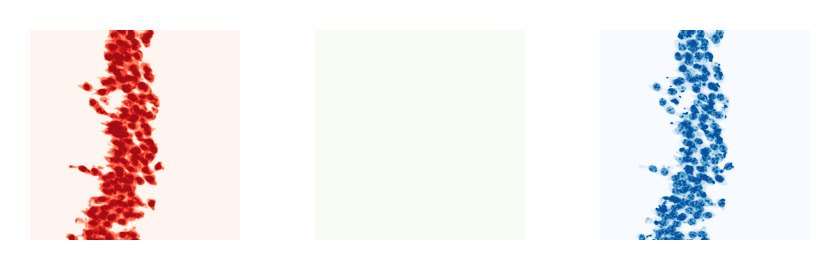

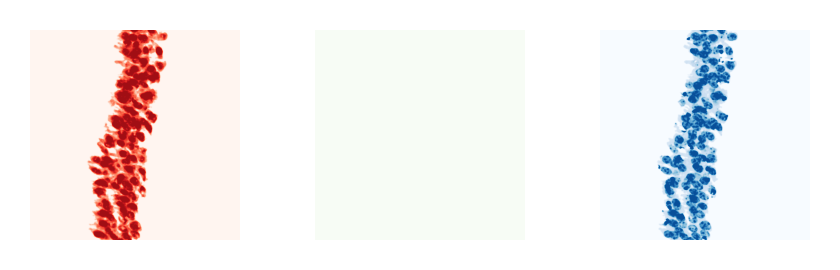

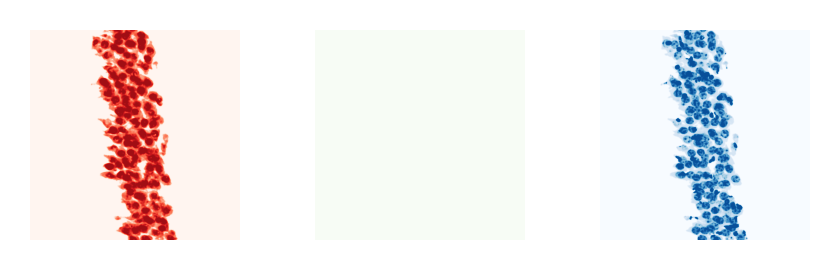

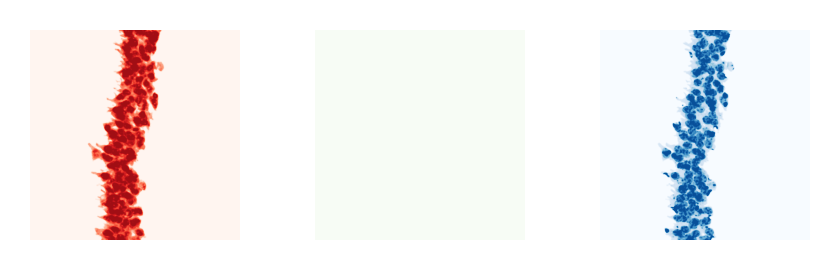

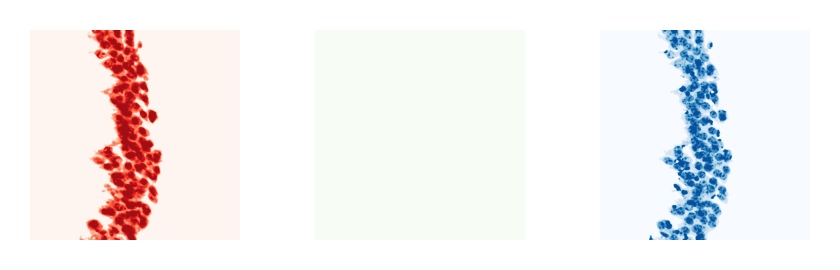

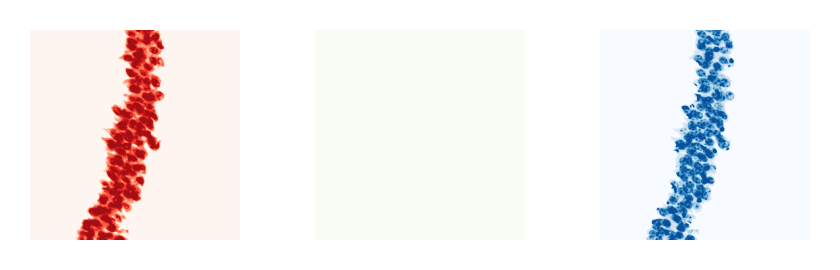

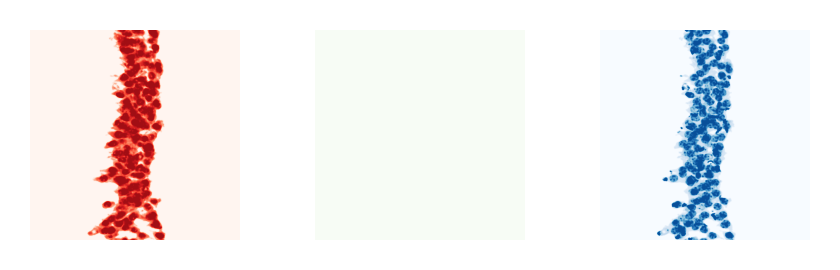

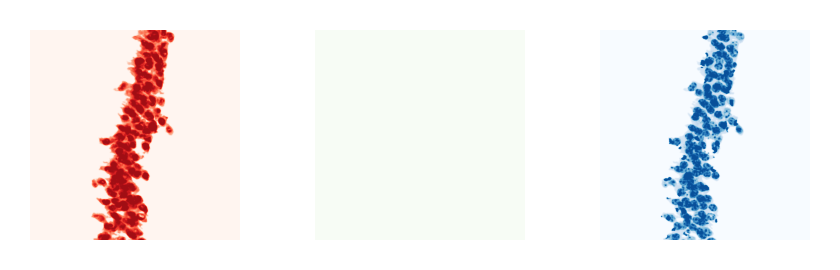

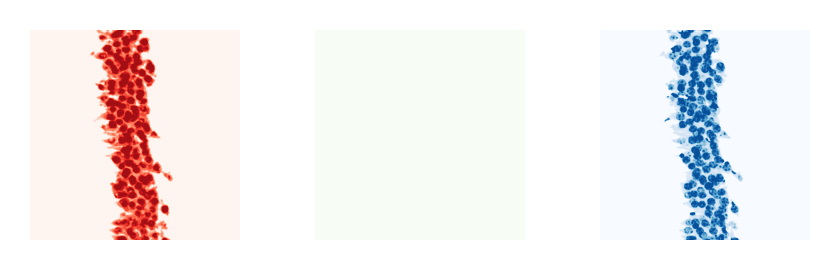

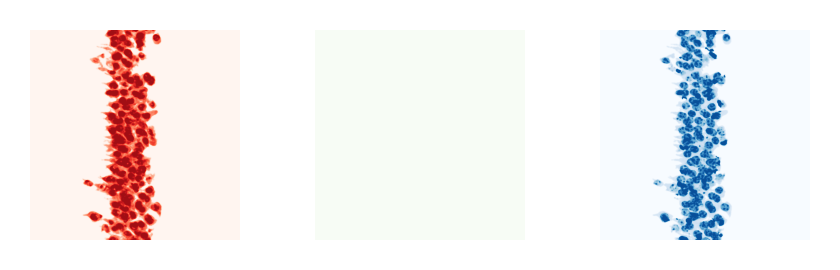

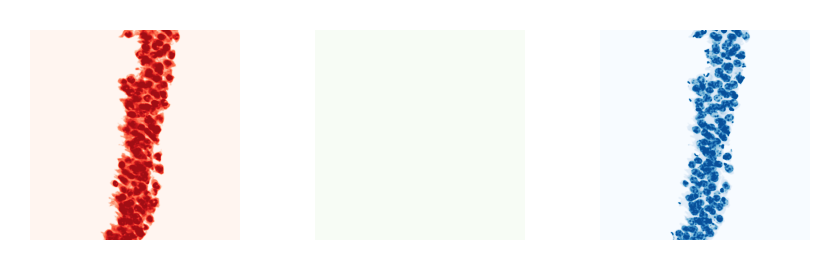

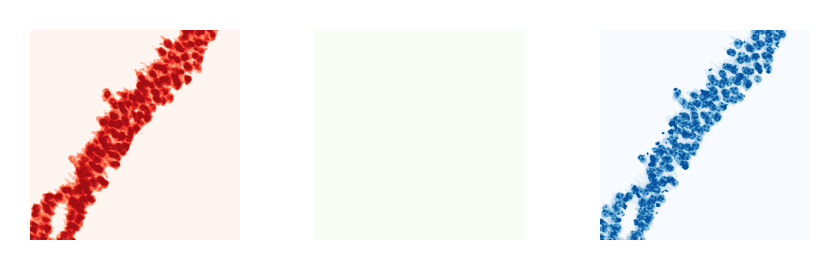

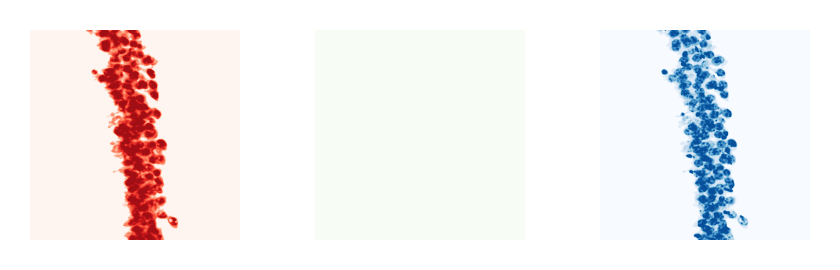

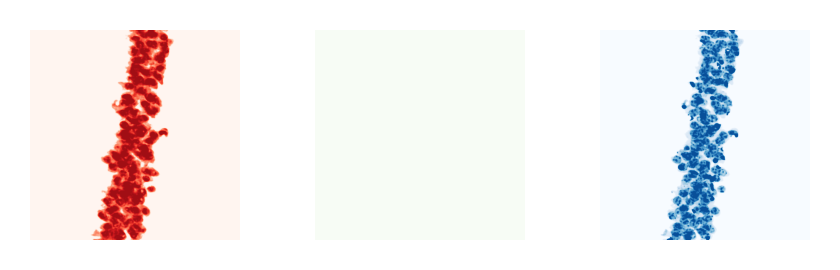

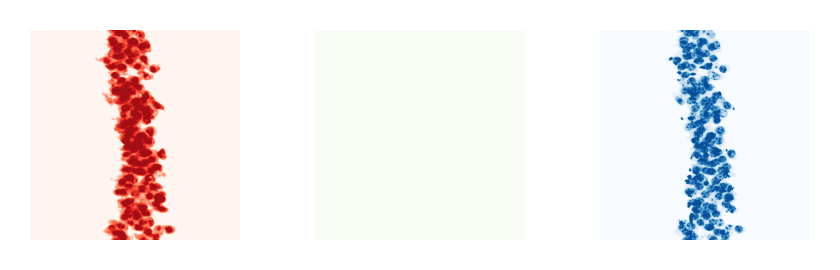

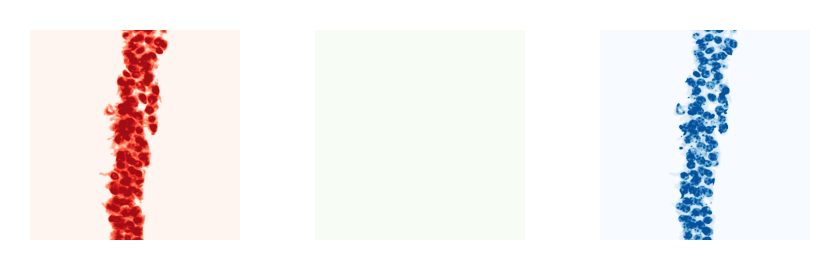

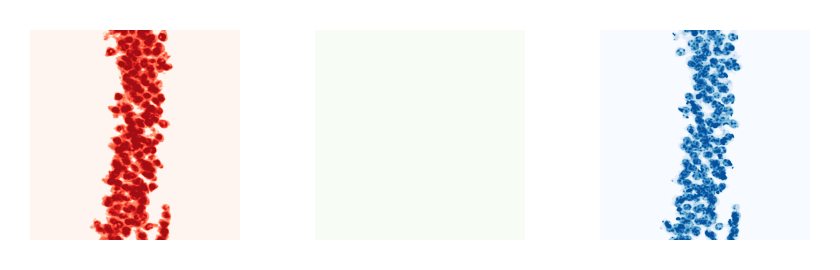

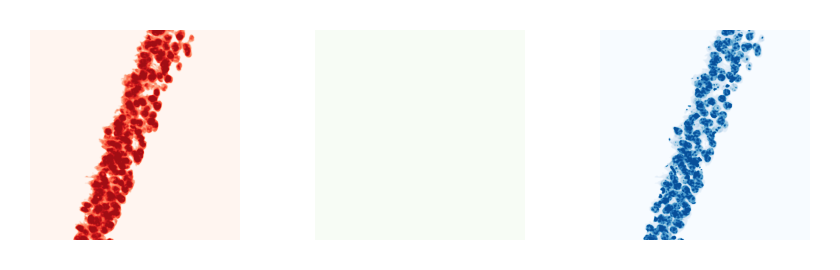

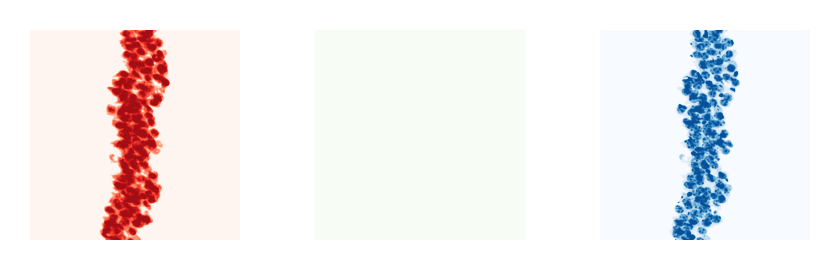

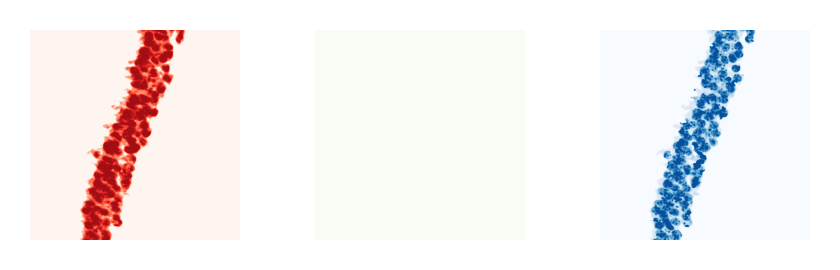

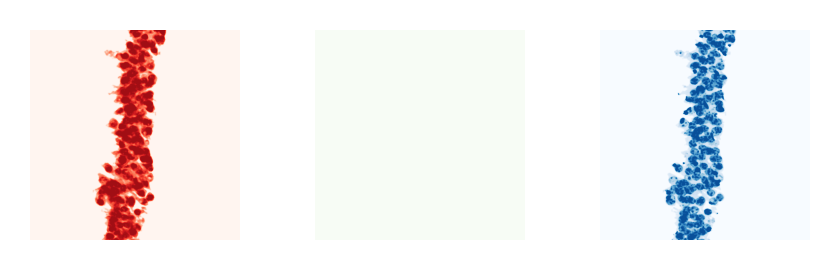

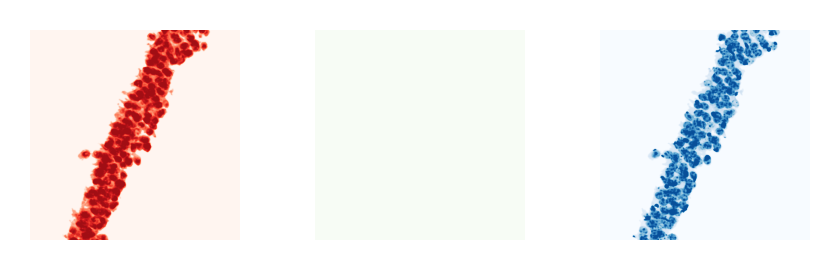

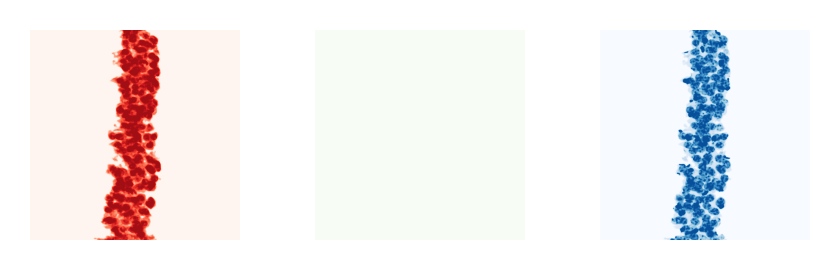

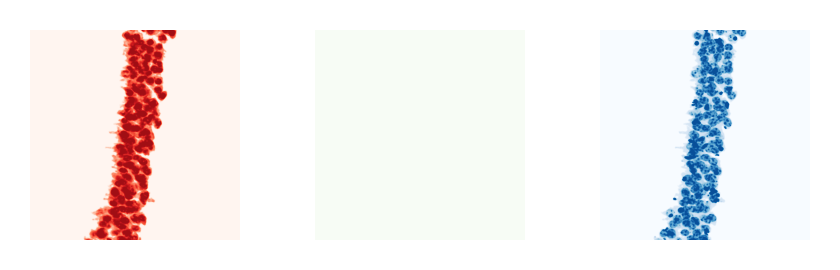

In [704]:
def qunatify_image_stack(curr_tif):
    tiff_data_raw = tifffile.imread(curr_tif)
    cell_layer_mask,tiff_data_masked = calc_cell_layer_mask(tiff_data_raw,thresh=0.2)
    tiff_data = preprocess_image(tiff_data_masked)
    rgb_stack = tiff_to_RGB_stack(tiff_data)
    split_proj(rgb_stack)

    nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3,channel_axis=3)
    results_dict = fit_cell_model(rgb_stack,channel_axis=3)
    cell_masks = results_dict['cell_masks']
    cell_masks, cell_masks_og = trim_edge_bound(cell_masks)
    save_masks(cell_masks,nuclear_masks,cell_masks_og,curr_tif)


# fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=300)
# ax[0].pcolorfast(np.sum(nuclear_masks,axis=0))
# ax[1].pcolorfast(np.sum(cell_masks,axis=0))


for curr_tif in my_tiffs:
    qunatify_image_stack(curr_tif)